In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
import glob
from pickle import dump, load
import PIL
from PIL import Image
import random
import time
import json
import nltk
from tqdm.notebook import tqdm

In [2]:
# Check for GPU availability
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, LSTM, MultiHeadAttention,
    RepeatVector, BatchNormalization, LayerNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(tf.config.list_physical_devices('GPU'))

2025-05-16 16:57:52.650260: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 16:57:52.819497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-16 16:57:52.877439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-16 16:57:52.892669: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 16:57:52.991716: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1747394874.954704    1830 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747394875.356208    1830 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747394875.356288    1830 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
class Config:
    # Model hyperparameters
    EMBEDDING_DIM = 256
    UNITS = 512     
    DROPOUT_RATE = 0.1   

    # Dataset parameters
    TRAIN_SIZE = 0.8
    VAL_SIZE = 0.1
    TEST_SIZE = 0.1

    # Training parameters
    BATCH_SIZE = 64
    EPOCHS = 20
    INITIAL_LR = 0.001
    LR_DECAY = 0.9

    # Caption parameters
    MAX_LENGTH = 34   # Will be calculated from the data
    VOCAB_SIZE = 6849    # Vocab size

    # Image Parameters
    IMG_H = 224
    IMG_W = 224

    # Paths
    MODEL_SAVE_PATH = "model_weights/model_"
    PICKLE_PATH = "pickles/"
    CAPTIONS_PATH = "archive/captions.txt"
    IMAGES_PATH = "archive/Images"
    
    def __init__(self):
        os.makedirs("model_weights", exist_ok=True)
        os.makedirs("pickles", exist_ok=True)

config = Config()

# Data Loading and Preprocessing

Loaded captions for 8091 images


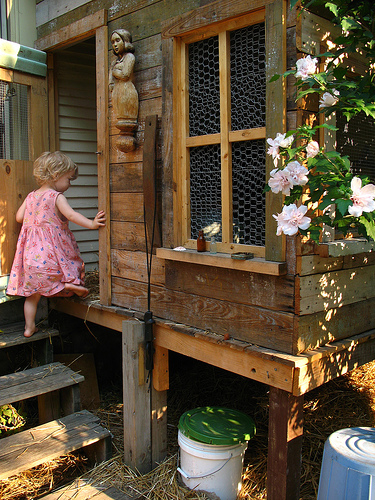

Sample captions for image '1000268201_693b08cb0e': A child in a pink dress is climbing up a set of stairs in an entry way ., A girl going into a wooden building ., A little girl climbing into a wooden playhouse .


In [4]:
def map_captions(text):
    captions = {} #this dict contains img_ids as keys and list of captions as values

    for line in text.split("\n"):
        # The captions.txt file is in format image,caption
        sentences = line.split(",") 
        if not sentences or len(sentences) < 2:
            continue
            
        # Remove .jpg from the image filename
        img_id = sentences[0].split(".")[0]
        
        # Skip header row
        if img_id == 'image':
            continue
            
        # Initialize list for this img_id if not already present
        if img_id not in captions:
            captions[img_id] = []
            
        # Append caption
        captions[img_id].append(",".join(sentences[1:]).strip())
    
    return captions

# Load captions from file
try:
    text = open(config.CAPTIONS_PATH, 'r', encoding='utf-8').read()
    captions = map_captions(text)
    print(f"Loaded captions for {len(captions)} images")
    im = Image.open('archive/Images/1000268201_693b08cb0e.jpg')
    display(im)
    print(f"Sample captions for image '1000268201_693b08cb0e': {captions['1000268201_693b08cb0e'][0]}, {captions['1000268201_693b08cb0e'][1]}, {captions['1000268201_693b08cb0e'][2]}")
except Exception as e:
    print(f"Error loading captions: {e}")

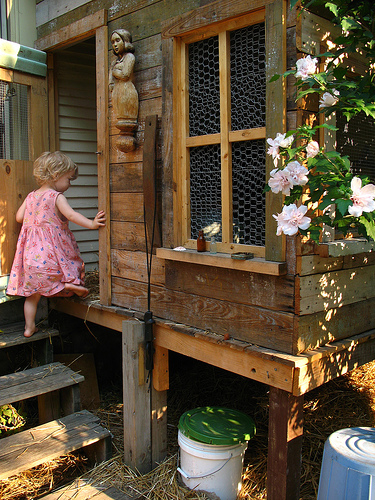

Sample captions for image '1000268201_693b08cb0e': startseq child in pink dress is climbing up set of stair in an entry way endseq, startseq girl going into wooden building endseq, startseq little girl climbing into wooden playhouse endseq


In [5]:
def preprocess_captions(captions):
    # Process each caption
    lemmatizer = nltk.WordNetLemmatizer()
    for img_id, caption_list in captions.items():
        for i in range(len(caption_list)):
            caption = caption_list[i]

            # remove punctuation
            caption = ''.join([ch for ch in caption if ch not in string.punctuation])
            
            # Add start and end sequence tokens
            caption = 'startseq ' + caption + ' endseq'
            
            # Convert to list of words
            words = caption.split()
            
            # Clean words
            words = [word.lower() for word in words]  # lowercase
            words = [word for word in words if len(word) > 1]  # remove 1-letter words
            words = [word for word in words if word.isalpha()]  # remove words with numbers
            words = [lemmatizer.lemmatize(word) for word in words]  # lemmatize
            
            # Convert back to string
            caption_list[i] = ' '.join(words)
    
    return captions

# Preprocess captions
processed_captions = preprocess_captions(captions.copy())
im = Image.open('archive/Images/1000268201_693b08cb0e.jpg')
display(im)
print(f"Sample captions for image '1000268201_693b08cb0e': {captions['1000268201_693b08cb0e'][0]}, {captions['1000268201_693b08cb0e'][1]}, {captions['1000268201_693b08cb0e'][2]}")

# Save processed captions
os.makedirs(config.PICKLE_PATH, exist_ok=True)
dump(processed_captions, open(f"{config.PICKLE_PATH}captions.pkl", "wb"))

In [6]:
img_paths = list(glob.glob(f"{config.IMAGES_PATH}/*.jpg"))
print(f"Found {len(img_paths)} images")

random.shuffle(img_paths)

train_size = int(len(img_paths) * config.TRAIN_SIZE)
val_size = int(len(img_paths) * config.VAL_SIZE)

# Create train, val, test splits
train_paths = img_paths[:train_size]
val_paths = img_paths[train_size:train_size+val_size]
test_paths = img_paths[train_size+val_size:]

print(f"Train set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")
print(f"Test set: {len(test_paths)} images")

Found 8091 images
Train set: 6472 images
Validation set: 809 images
Test set: 810 images


In [7]:
def extract_ids_from_paths(paths):
    result = []
    for path in paths:
        # Get filename without extension
        filename = os.path.basename(path)
        img_id = filename.split('.')[0]
        result.append(img_id)
    return result

train_ids = extract_ids_from_paths(train_paths)
val_ids = extract_ids_from_paths(val_paths)
test_ids = extract_ids_from_paths(test_paths)

# Create dictionaries for each split
train_captions = {img_id: processed_captions[img_id] for img_id in train_ids}
val_captions = {img_id: processed_captions[img_id] for img_id in val_ids}
test_captions = {img_id: processed_captions[img_id] for img_id in test_ids}

print(f"Train captions: {len(train_captions)}")
print(f"Validation captions: {len(val_captions)}")
print(f"Test captions: {len(test_captions)}")

Train captions: 6472
Validation captions: 809
Test captions: 810


In [8]:
dump(train_captions, open(f"{config.PICKLE_PATH}train_captions.pkl", "wb"))
dump(val_captions, open(f"{config.PICKLE_PATH}val_captions.pkl", "wb"))
dump(test_captions, open(f"{config.PICKLE_PATH}test_captions.pkl", "wb"))

# Tokenized Captions

In [9]:
# Determine maximum caption length for padding
def get_max_length(captions_dict):
    max_length = 0
    for _, captions_list in captions_dict.items():
        for caption in captions_list:
            length = len(caption.split())
            if length > max_length:
                max_length = length
    return max_length

config.MAX_LENGTH = get_max_length(train_captions)
print(f"Maximum caption length: {config.MAX_LENGTH} words")

Maximum caption length: 34 words


In [10]:
def create_tokenizer(captions_dict, top_k=3000):
    clean_captions_list = [caption for captions in captions_dict.values() for caption in captions] # creates a flat list of captions
    tokenizer = Tokenizer(num_words=top_k, oov_token="<unk>")
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    tokenizer.fit_on_texts(clean_captions_list)
    return tokenizer

tokenizer = create_tokenizer(train_captions)
config.VOCAB_SIZE = len(tokenizer.word_index) + 1
print(config.VOCAB_SIZE)

6860


In [11]:
def tokenize_cap(tokenizer, captions_dict, pad_len=config.MAX_LENGTH):
    tok_captions = {img_name: pad_sequences(tokenizer.texts_to_sequences(captions), maxlen=pad_len, padding='post') for img_name, captions in captions_dict.items()}
    return tok_captions

train_captions = tokenize_cap(tokenizer, train_captions)
val_captions = tokenize_cap(tokenizer, val_captions)
test_captions = tokenize_cap(tokenizer, test_captions)

# Image Processing

In [12]:
def load_image_model():
    base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
    
    return model

image_model = load_image_model()
print("VGG16 model loaded for feature extraction")

I0000 00:00:1747394878.527739    1830 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747394878.527808    1830 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747394878.527836    1830 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747394878.703320    1830 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747394878.703422    1830 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-16

VGG16 model loaded for feature extraction


In [13]:
def preprocess_image(image_path, img_h=Config.IMG_H, img_w=Config.IMG_W):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_h, img_w))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    return img

def extract_features(image_path, model):
    try:
        # Preprocess the image
        img = preprocess_image(image_path)
        
        # Extract features
        features = model.predict(img, verbose=0)

        # Remove batch dimension
        features = tf.squeeze(features, axis=0)
        
        return features
    except Exception as e:
        print(f"Error extracting features from {image_path}: {e}")
        return None

In [14]:
def extract_features_for_dataset(image_paths, model):
    features = {}

    for path in tqdm(image_paths, desc="Extracting features"):

        img_id = os.path.basename(path).split('.')[0]
        
        # Extract features
        img_features = extract_features(path, model)
        
        if img_features is not None:
            features[img_id] = img_features
    
    return features

start_time = time.time()

# Extract for train set
train_features = extract_features_for_dataset(train_paths, image_model)
print(f"Extracted features for {len(train_features)} training images")

# Extract for validation set
val_features = extract_features_for_dataset(val_paths, image_model)
print(f"Extracted features for {len(val_features)} validation images")

# Extract for test set
test_features = extract_features_for_dataset(test_paths, image_model)
print(f"Extracted features for {len(test_features)} test images")

# # Save features
# dump(train_features, open(f"{config.PICKLE_PATH}train_features.pkl", "wb"))
# dump(val_features, open(f"{config.PICKLE_PATH}val_features.pkl", "wb"))
# dump(test_features, open(f"{config.PICKLE_PATH}test_features.pkl", "wb"))

# Print time taken
elapsed_time = time.time() - start_time
print(f"Feature extraction completed in {elapsed_time:.2f} seconds")

Extracting features:   0%|          | 0/6472 [00:00<?, ?it/s]

I0000 00:00:1747394879.745262   11719 service.cc:146] XLA service 0x7f10f4004220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747394879.745297   11719 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-05-16 16:57:59.756121: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-16 16:57:59.814922: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1747394880.854311   11719 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Extracted features for 6472 training images


Extracting features:   0%|          | 0/809 [00:00<?, ?it/s]

Extracted features for 809 validation images


Extracting features:   0%|          | 0/810 [00:00<?, ?it/s]

Extracted features for 810 test images
Feature extraction completed in 357.30 seconds


# Data Generator

In [15]:
def create_dataset(features_dict, tokenized_captions_dict, batch_size=64, shuffle=True, buffer_size=1000):
    # Lists to hold features and captions
    all_img_features = []
    all_captions = []
    
    # Convert dictionaries to lists
    for img_id, features in features_dict.items():
        captions = tokenized_captions_dict.get(img_id)
        if captions is not None:
            for caption in captions:
                all_img_features.append(features)
                all_captions.append(caption)
    
    # Convert to numpy arrays
    all_img_features = np.array(all_img_features)
    all_captions = np.array(all_captions)
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((all_img_features, all_captions))
    
    # Shuffle if required
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    
    # Batch the dataset
    dataset = dataset.batch(batch_size)
    
    # Prefetch for performance
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [16]:
def prepare_datasets(train_features, val_features, test_features, train_captions, val_captions, test_captions, batch_size=64):
    # Create datasets
    train_dataset = create_dataset(
        train_features, train_captions, 
        batch_size=batch_size, shuffle=True
    )
    
    val_dataset = create_dataset(
        val_features, val_captions,
        batch_size=batch_size, shuffle=False
    )
    
    test_dataset = create_dataset(
        test_features, test_captions,
        batch_size=batch_size, shuffle=False
    )
    
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = prepare_datasets(train_features, val_features, test_features, train_captions, val_captions, test_captions)

# Model Architecture

In [17]:
# Implement Additive Attention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        attention_hidden_layer = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # Apply attention weights to features
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [18]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, dropout_rate=0.3):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(
            embedding_dim, 
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.bn = tf.keras.layers.BatchNormalization()

    def call(self, x, training=False):
        # x input shape: (batch_size, H, W, C)
        # Reshape features to flatten spatial dimensions: (batch_size, H*W, C)
        batch_size = tf.shape(x)[0]
        _, H, W, C = x.shape
        x = tf.reshape(x, (batch_size, H * W, C))

        # Pass through the fully connected layer
        # x shape: (batch_size, H*W, embedding_dim)
        x = self.fc(x)
        
        # Add batch normalization
        x = self.bn(x, training=training)
        
        # Apply ReLU activation
        x = tf.nn.relu(x)
        
        # Apply dropout for regularization
        x = self.dropout(x, training=training)
        
        return x

In [19]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size, dropout_rate=0.4):
    super(RNN_Decoder, self).__init__()
    self.units = units
    
    # Embedding layer to convert word indices to dense vectors
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    
    # GRU layer for sequence processing - use two layers for better generalization
    self.gru1 = tf.keras.layers.GRU(
        self.units,
        return_sequences=True,
        return_state=True,
        recurrent_initializer='glorot_uniform',
        recurrent_dropout=0.2,
        recurrent_regularizer=tf.keras.regularizers.l2(0.0001)
    )
    
    self.gru2 = tf.keras.layers.GRU(
        self.units,
        return_sequences=True,
        return_state=True, 
        recurrent_initializer='glorot_uniform',
        recurrent_dropout=0.2
    )
    
    # Dense layers for transforming GRU output with L2 regularization
    self.fc1 = tf.keras.layers.Dense(
        self.units, 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )
    
    # Output layer for vocabulary prediction
    self.fc2 = tf.keras.layers.Dense(
        vocab_size,
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )
    
    # Dropout layers to prevent overfitting
    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
    self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    
    # Layer normalization
    self.layernorm = tf.keras.layers.LayerNormalization()
    
    # Attention mechanism instance
    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden, training=False):
    # Calculate context vector using attention
    # context_vector shape == (batch_size, embedding_dim)
    context_vector, attention_weights = self.attention(features, hidden)
    
    # Embed the input word index
    # x shape after embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    
    # Apply dropout to embeddings
    x = self.dropout1(x, training=training)
    
    # Concatenate the context vector and embedded word
    # context_vector expanded shape == (batch_size, 1, embedding_dim)
    # x shape after concatenation == (batch_size, 1, embedding_dim + embedding_dim)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
    # Pass the concatenated vector through the first GRU layer
    # output shape == (batch_size, 1, units)
    # state shape == (batch_size, units)
    gru1_output_package = self.gru1(x, initial_state=hidden)
    if isinstance(gru1_output_package, (list, tuple)) and len(gru1_output_package) > 2:
        # Tensorflow GPU known bug
        output1 = gru1_output_package[0]
        # The rest of the items are assumed to be individual states for the batch
        individual_states = gru1_output_package[1:]
        # Stack them along axis 0 to form the batched state
        state1 = tf.stack(individual_states, axis=0)
    else:
        # Standard unpacking if the GRU behaves normally
        output1, state1 = gru1_output_package

    
    # Apply dropout between GRU layers
    output1 = self.dropout2(output1, training=training)
    
    # Pass through second GRU layer
    gru2_output_package = self.gru2(output1, initial_state=state1)
    if isinstance(gru2_output_package, (list, tuple)) and len(gru2_output_package) > 2:
        # Tensorflow GPU known bug
        output2 = gru2_output_package[0]
        # The rest of the items are assumed to be individual states for the batch
        individual_states = gru2_output_package[1:]
        # Stack them along axis 0 to form the batched state
        state2 = tf.stack(individual_states, axis=0)
    else:
        # Standard unpacking if the GRU behaves normally
        output2, state2 = gru2_output_package

    
    # Use the final state for the next step
    state = state2
    
    # Pass the GRU output through Dense layers
    # x shape == (batch_size, 1, units)
    x = self.fc1(output2)
    
    # Apply layer normalization
    x = self.layernorm(x)
    
    # Apply ReLU activation
    x = tf.nn.relu(x)
    
    # Reshape for the final prediction layer
    # x shape == (batch_size, units)
    x = tf.reshape(x, (-1, x.shape[2]))
    
    # Final prediction layer (logits)
    # x shape == (batch_size, vocab_size)
    x = self.fc2(x)
    
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,  # Model outputs logits
    reduction='none') # Calculate loss per element for masking

In [21]:
def loss_function(real, pred):
  # Create a mask to ignore padding tokens (assuming 0 is padding index)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  # Cast mask to the same dtype as loss
  mask = tf.cast(mask, dtype=loss_.dtype)

  # Apply mask - loss for padding tokens becomes 0
  loss_ *= mask

  # Return the mean loss over non-padding elements
  return tf.reduce_mean(loss_)

In [22]:
loss_plot = []

In [23]:
encoder = CNN_Encoder(config.EMBEDDING_DIM)
decoder = RNN_Decoder(config.EMBEDDING_DIM, config.UNITS, config.VOCAB_SIZE)

In [24]:
def train_step(img_tensor, target, tokenizer, encoder, decoder, optimizer):
  loss = 0

  # Initialize decoder hidden state for the batch
  hidden = decoder.reset_state(batch_size=target.shape[0])

  # Prepare initial decoder input: the startseq token
  # dec_input shape: (batch_size, 1)
  dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1) 

  # Use GradientTape to record operations for automatic differentiation
  with tf.GradientTape() as tape:
      # 1. Encode the image features
      # features shape: (batch_size, num_features, embedding_dim)
      features = encoder(img_tensor)

      # 2. Decode step-by-step using Teacher Forcing
      for i in range(1, target.shape[1]): # Loop through the caption sequence
          # Pass features, previous input, and hidden state to the decoder
          # predictions shape: (batch_size, vocab_size)
          # hidden shape: (batch_size, units)
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          # Calculate loss for the current time step
          loss += loss_function(target[:, i], predictions)

          # Teacher Forcing: Use the actual next word as the next input
          # dec_input shape: (batch_size, 1)
          dec_input = tf.expand_dims(target[:, i], 1)

  # Calculate total loss for the batch (average loss per sequence)
  total_loss = (loss / int(target.shape[1])) # Average over sequence length

  # Get all trainable variables from both models
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  # Calculate gradients of the loss with respect to trainable variables
  gradients = tape.gradient(loss, trainable_variables)

  # Apply gradients to update model weights using the optimizer
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  # Return batch loss and total loss (average per sequence)
  return loss, total_loss

In [25]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

Starting Training...
Current learning rate: 0.001
Epoch 1 Batch 0 Loss 2.5842
Epoch 1 Batch 100 Loss 1.5225
Epoch 1 Batch 200 Loss 1.1748
Epoch 1 Batch 300 Loss 1.1362
Epoch 1 Batch 400 Loss 1.0546
Epoch 1 Batch 500 Loss 1.1199


2025-05-15 13:16:05.274850: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-15 13:17:04.580767: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 Validation Loss 1.100629
New best validation loss: 1.100629
Saved checkpoint for epoch 1 at ./checkpoints/train/ckpt-1
Epoch 1 Loss 1.281293
Time taken for 1 epoch 769.35 sec

Current learning rate: 0.001
Epoch 2 Batch 0 Loss 1.1844
Epoch 2 Batch 100 Loss 1.0565
Epoch 2 Batch 200 Loss 0.9595
Epoch 2 Batch 300 Loss 0.8666
Epoch 2 Batch 400 Loss 0.9799
Epoch 2 Batch 500 Loss 0.8638


2025-05-15 13:29:16.009648: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 Validation Loss 1.030268
New best validation loss: 1.030268
Saved checkpoint for epoch 2 at ./checkpoints/train/ckpt-2
Epoch 2 Loss 0.980240
Time taken for 1 epoch 731.39 sec

Current learning rate: 0.001
Epoch 3 Batch 0 Loss 0.9642
Epoch 3 Batch 100 Loss 0.9692
Epoch 3 Batch 200 Loss 0.8644
Epoch 3 Batch 300 Loss 0.9086
Epoch 3 Batch 400 Loss 0.7770
Epoch 3 Batch 500 Loss 0.7334
Epoch 3 Validation Loss 1.019041
New best validation loss: 1.019041
Saved checkpoint for epoch 3 at ./checkpoints/train/ckpt-3
Epoch 3 Loss 0.873914
Time taken for 1 epoch 723.59 sec

Current learning rate: 0.001
Epoch 4 Batch 0 Loss 0.8695
Epoch 4 Batch 100 Loss 0.7798
Epoch 4 Batch 200 Loss 0.7953
Epoch 4 Batch 300 Loss 0.8025
Epoch 4 Batch 400 Loss 0.7219
Epoch 4 Batch 500 Loss 0.7184


2025-05-15 13:54:05.302388: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 Validation Loss 1.029938
Validation loss did not improve. Patience: 1/3
Epoch 4 Loss 0.795081
Time taken for 1 epoch 765.25 sec

Current learning rate: 0.001
Epoch 5 Batch 0 Loss 0.8032
Epoch 5 Batch 100 Loss 0.7135
Epoch 5 Batch 200 Loss 0.6548
Epoch 5 Batch 300 Loss 0.6426
Epoch 5 Batch 400 Loss 0.6739
Epoch 5 Batch 500 Loss 0.6886
Epoch 5 Validation Loss 1.049075
Validation loss did not improve. Patience: 2/3
Epoch 5 Loss 0.727136
Time taken for 1 epoch 751.72 sec

Current learning rate: 0.0009000000000000001
Epoch 6 Batch 0 Loss 0.6362
Epoch 6 Batch 100 Loss 0.6653
Epoch 6 Batch 200 Loss 0.7077
Epoch 6 Batch 300 Loss 0.6317
Epoch 6 Batch 400 Loss 0.6447
Epoch 6 Batch 500 Loss 0.5598
Epoch 6 Validation Loss 1.090142
Validation loss did not improve. Patience: 3/3
Early stopping triggered after 6 epochs
Training Finished.


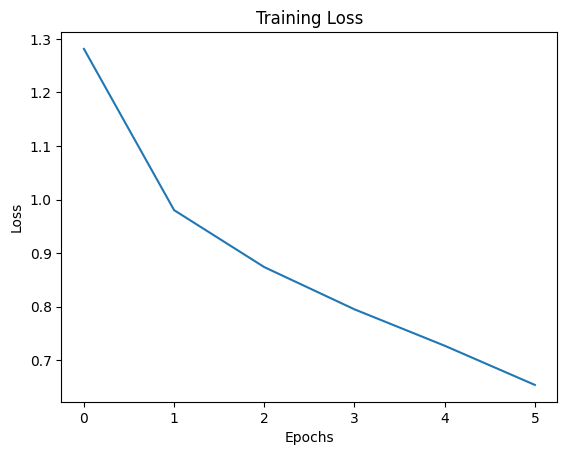

In [ ]:
print("Starting Training...")
num_steps = len(train_dataset) # Example: Calculate number of batches per epoch

# Learning rate scheduler
def learning_rate_schedule(epoch, lr):
    if epoch < 5:
        return config.INITIAL_LR
    else:
        return lr * config.LR_DECAY

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)

# Early stopping parameters
patience = 3
best_loss = float('inf')
wait = 0
early_stop = False

for epoch in range(start_epoch, config.EPOCHS):
    start_time = time.time()
    epoch_total_loss = 0
    
    # Update learning rate based on epoch
    current_lr = learning_rate_schedule(epoch, config.INITIAL_LR)
    optimizer.learning_rate.assign(current_lr)
    print(f"Current learning rate: {current_lr}")
    
    # Iterate over batches in the training dataset
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        # Perform one training step
        batch_loss, t_loss = train_step(img_tensor, target, tokenizer, encoder, decoder, optimizer)
        epoch_total_loss += t_loss # Accumulate average loss per sequence

        # Print progress periodically
        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy() / int(target.shape[1])
            print(f'Epoch {epoch + 1} Batch {batch} Loss {t_loss.numpy():.4f}') # Print average loss for the batch

    # Calculate average loss over the entire epoch
    avg_epoch_loss = epoch_total_loss / num_steps
    loss_plot.append(avg_epoch_loss) 

    # Validate on validation dataset
    val_loss = 0
    val_steps = 0
    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        # Get encoder features
        features = encoder(img_tensor, training=False)
        
        hidden = decoder.reset_state(batch_size=target.shape[0])
        dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)
        
        loss = 0
        
        # Compute validation loss for this batch
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden, training=False)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        
        val_loss += (loss / int(target.shape[1]))
        val_steps += 1
    
    # Average validation loss
    avg_val_loss = val_loss / val_steps
    print(f'Epoch {epoch + 1} Validation Loss {avg_val_loss:.6f}')
    
    # Early stopping check
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        wait = 0
        print(f"New best validation loss: {best_loss:.6f}")
        
        # Save checkpoint for best model
        save_path = ckpt_manager.save()
        print(f'Saved checkpoint for epoch {epoch+1} at {save_path}')
    else:
        wait += 1
        print(f"Validation loss did not improve. Patience: {wait}/{patience}")
        
        if wait >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            early_stop = True
            break
    
    # Print epoch summary
    print(f'Epoch {epoch + 1} Loss {avg_epoch_loss:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start_time:.2f} sec\n')
    
    if early_stop:
        break

print("Training Finished.")

import matplotlib.pyplot as plt
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
# ckpt.restore('./checkpoints/train/ckpt-3')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import nltk # For BLEU score
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def ids_to_words(token_ids, tokenizer):
    words = []
    for token_id in token_ids:
        if token_id == 0: # Skip padding
            continue
        word = tokenizer.index_word.get(token_id, "<unk>")
        if word == "endseq": # Stop at endseq
            break
        if word != "startseq" and word != "<unk>": # Don't include startseq or unk in final sentence
            words.append(word)
    return " ".join(words)

# Function to Generate Caption for a single image's features
def generate_caption(image_features_vgg, encoder_model, decoder_model, tokenizer, max_caption_length):
    # Set training=False for both models to use them in inference mode
    hidden = decoder_model.reset_state(batch_size=1) # Batch size is 1 for single image

    img_tensor_val = tf.expand_dims(image_features_vgg, 0)
    features = encoder_model(img_tensor_val, training=False) # Shape: (1, num_features, embedding_dim)

    # Start decoding with the <startseq> token
    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0) # Shape: (1, 1)
    result_caption_ids = []
    
    # Keep track of previously generated words to penalize repetition
    generated_word_counts = {}
    
    for i in range(max_caption_length):
        predictions, hidden, _ = decoder_model(dec_input, features, hidden, training=False)
        
        # Fix for TensorFlow issues with GRU state
        if len(tf.shape(hidden)) == 1:
            hidden = tf.expand_dims(hidden, 0)
        
        # Add repetition penalty to avoid repeating words
        predictions_logits = predictions[0].numpy()
        
        # Apply penalties for repeated words
        for word_id, count in generated_word_counts.items():
            if count > 0:
                # Apply increasing penalty based on number of repetitions
                penalty = 1.0 + count * 1.5
                if word_id < len(predictions_logits):
                    predictions_logits[word_id] /= penalty
        
        # Find word with highest adjusted probability
        predicted_id = np.argmax(predictions_logits)
        
        # Add predicted word to result
        result_caption_ids.append(predicted_id)
        
        # Update word count for repetition penalty
        if predicted_id in generated_word_counts:
            generated_word_counts[predicted_id] += 1
        else:
            generated_word_counts[predicted_id] = 1
        
        # Exit if end token is predicted
        if tokenizer.index_word[predicted_id] == 'endseq':
            break
        
        # Feed the predicted ID back as the next input
        dec_input = tf.expand_dims([predicted_id], 0)

    return ids_to_words(result_caption_ids, tokenizer)

# Function for beam search - provides more diverse captions
def beam_search_caption(image_features, encoder_model, decoder_model, tokenizer, max_length=20, beam_width=3, diversity_penalty=0.5):
    # Encode image features
    img_tensor = tf.expand_dims(image_features, 0)  
    features = encoder_model(img_tensor, training=False)
    
    # Initial hidden state
    hidden = decoder_model.reset_state(batch_size=1)
    
    # Start with startseq token
    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    
    # Initial beam with the startseq token
    beams = [(0.0, [tokenizer.word_index['startseq']], hidden)]
    completed_beams = []
    
    # Track words used to apply diversity penalty
    for _ in range(max_length - 1):
        candidates = []
        
        # Expand each beam
        for score, sequence, current_hidden in beams:
            # If sequence ends with endseq, add to completed beams
            if sequence[-1] == tokenizer.word_index.get('endseq', -1):
                completed_beams.append((score, sequence))
                continue
            
            # Prepare input
            dec_input = tf.expand_dims([sequence[-1]], 0)
            
            # Get predictions
            predictions, new_hidden, _ = decoder_model(dec_input, features, current_hidden, training=False)
            
            # TensorFlow issue fix
            if len(tf.shape(new_hidden)) == 1:
                new_hidden = tf.expand_dims(new_hidden, 0)
            
            # Get top-k predictions
            predictions = tf.nn.softmax(predictions[0]).numpy()
            top_indices = np.argsort(predictions)[-beam_width:]
            
            # Add diversity penalty for words already in sequence
            for word_idx in sequence:
                predictions[word_idx] /= (1.0 + diversity_penalty)
            
            # Create new candidates
            for idx in top_indices:
                word_probability = predictions[idx]
                if word_probability > 0:
                    # Logarithmic scoring to avoid multiplication underflow
                    new_score = score - np.log(word_probability)
                    new_seq = sequence + [idx]
                    candidates.append((new_score, new_seq, new_hidden))
        
        # No more candidates
        if not candidates:
            break
            
        # Sort candidates by score (lower is better)
        candidates.sort(key=lambda x: x[0])
        
        # Keep only top beams
        beams = candidates[:beam_width]
    
    # Add remaining beams to completed list
    for score, sequence, _ in beams:
        if sequence[-1] != tokenizer.word_index.get('endseq', -1):
            completed_beams.append((score, sequence + [tokenizer.word_index.get('endseq', -1)]))
    
    # Sort completed sequences by score
    completed_beams.sort(key=lambda x: x[0])
    
    # Return best sequence if found, otherwise return from best beam
    if completed_beams:
        _, best_sequence = completed_beams[0]
        return ids_to_words(best_sequence, tokenizer)
    else:
        _, best_sequence, _ = beams[0]
        return ids_to_words(best_sequence, tokenizer)

# Function to Test Model on a Single Image from Path
def test_single_image(image_path, image_feature_extractor_model, encoder_model, decoder_model, tokenizer, max_caption_length, original_raw_captions_dict=None):
    img = Image.open(image_path)
   
    vgg_features = extract_features(image_path, image_feature_extractor_model) 

    print("Image:", image_path)
    display(img)

    print("Generating captions...")
    
    # Generate with both methods
    standard_caption = generate_caption(vgg_features, encoder_model, decoder_model, tokenizer, max_caption_length)
    beam_caption = beam_search_caption(vgg_features, encoder_model, decoder_model, tokenizer, max_length=max_caption_length, beam_width=3)
    
    print("Standard Caption:", standard_caption)
    print("Beam Search Caption:", beam_caption)

    if original_raw_captions_dict:
        img_id = os.path.basename(image_path).split('.')[0]
        if img_id in original_raw_captions_dict:
            print("\nOriginal Captions:")
            for orig_cap in original_raw_captions_dict[img_id]:
                print("- ", orig_cap)
        else:
            print(f"\nNo original captions found for image ID: {img_id} in the provided dictionary.")

Evaluating model on test images:
Image: archive/Images/2370481277_a3085614c9.jpg


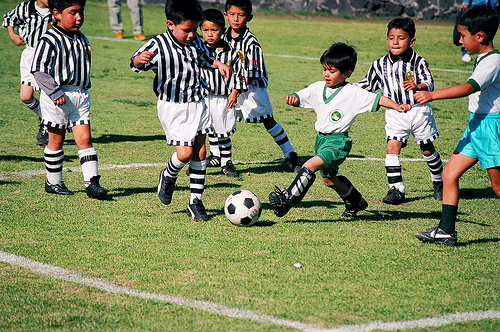

Generating captions...
Standard Caption: two boy are playing soccer
Beam Search Caption: two boy are playing soccer

Original Captions:
-  startseq group of young boy playing soccer endseq
-  startseq little boy in green is kicking soccer ball and boy in referee shirt are following him endseq
-  startseq young boy kick soccer ball while six others play but are dressed a referee endseq
-  startseq little boy play soccer on the field endseq
-  startseq small child kick soccer ball on soccer field endseq

--------------------------------------------------

Image: archive/Images/2604305843_ebe3e8a328.jpg


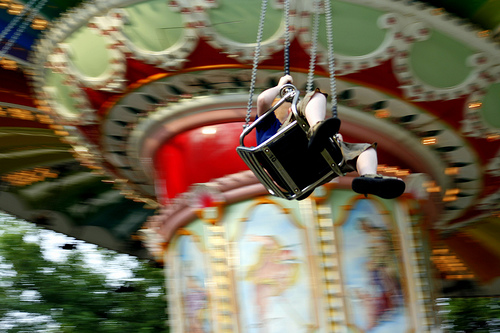

Generating captions...
Standard Caption: 
Beam Search Caption: boy on ride in the air

Original Captions:
-  startseq child on an amusement park swing ride endseq
-  startseq lone swinger on swing ride at the fair endseq
-  startseq person sits in chair suspended by chain at an amusement park endseq
-  startseq kid ride high on fair swing endseq
-  startseq man is sitting in swing on carnival ride endseq

--------------------------------------------------

Image: archive/Images/244870123_dcb6e53643.jpg


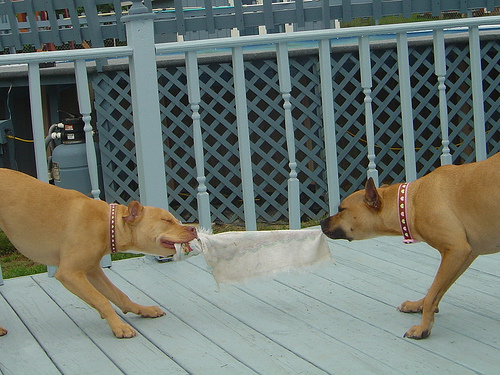

Generating captions...
Standard Caption: tan dog is walking down sidewalk with tan dog
Beam Search Caption: tan dog is walking down sidewalk

Original Captions:
-  startseq two dog are tugging at piece of white material endseq
-  startseq two dog fight over piece of cloth endseq
-  startseq two dog tug on towel endseq
-  startseq two dog with rag in their mouth endseq
-  startseq two large black dog with red studded collar pulling on end of white rag on porch endseq

--------------------------------------------------

Image: archive/Images/3363836972_c87b58c948.jpg


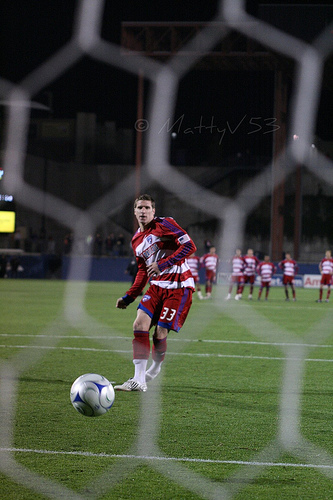

Generating captions...
Standard Caption: man in red and white uniform is about to kick soccer ball
Beam Search Caption: man in red and white uniform playing soccer

Original Captions:
-  startseq soccer player kicking goal in endseq
-  startseq soccer player kick ball into the unmanned goal endseq
-  startseq soccer player prepares to kick the ball endseq
-  startseq man in red white and blue sport uniform on field with soccer ball above ground in front of him endseq
-  startseq view of soccer ball being kicked into goal net endseq

--------------------------------------------------

Image: archive/Images/1026685415_0431cbf574.jpg


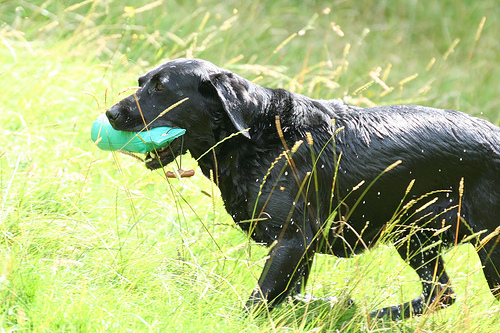

Generating captions...
Standard Caption: black dog with black collar running in the grass
Beam Search Caption: black dog is chasing ball

Original Captions:
-  startseq black dog carry green toy in his mouth a he walk through the grass endseq
-  startseq black dog carrying something through the grass endseq
-  startseq black dog ha blue toy in it mouth endseq
-  startseq dog in grass with blue item in his mouth endseq
-  startseq wet black dog is carrying green toy through the grass endseq

--------------------------------------------------



In [32]:
# Evaluate model on multiple test images
print("Evaluating model on test images:")

# Select a few test images randomly
num_samples = 5
sample_img_paths = random.sample(test_paths, num_samples)

for img_path in sample_img_paths:
    test_single_image(img_path, image_model, encoder, decoder, tokenizer, config.MAX_LENGTH, original_raw_captions_dict=processed_captions)
    print("\n" + "-"*50 + "\n")

Calculating BLEU scores...


[nltk_data] Downloading package punkt to /home/akhil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Generating captions for BLEU evaluation:   0%|          | 0/30 [00:00<?, ?it/s]


BLEU Score Results:
Beam Search BLEU-1: 0.4738
Beam Search BLEU-4: 0.1082
Greedy Decoding BLEU-1: 0.2530
Greedy Decoding BLEU-4: 0.0415


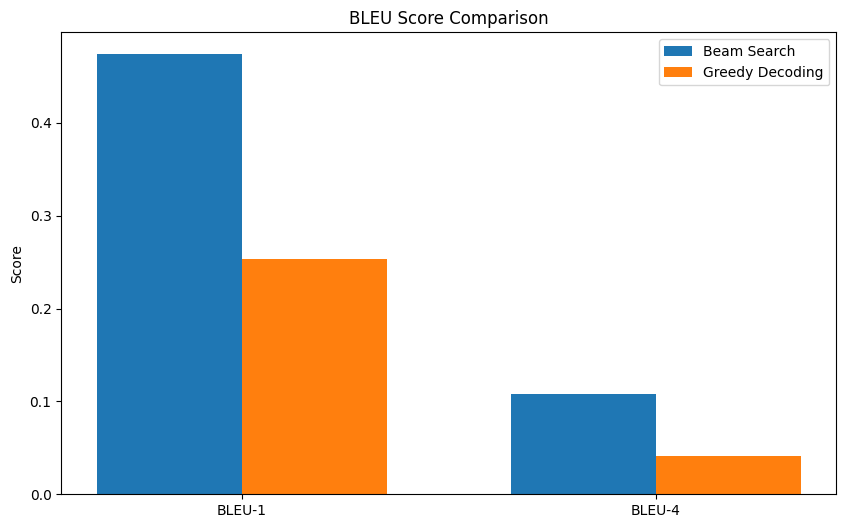

In [ ]:
# Compare beam search vs greedy decoding with BLEU score
def calculate_bleu_scores(image_paths, image_model, encoder, decoder, tokenizer, max_length, references_dict, num_samples=50):
    # Sample images if more than num_samples
    if len(image_paths) > num_samples:
        sample_paths = random.sample(image_paths, num_samples)
    else:
        sample_paths = image_paths
    
    # Lists to hold generated captions and references
    beam_captions = []
    greedy_captions = []
    all_references = []
    
    # Generate captions for each image
    for img_path in tqdm(sample_paths, desc="Generating captions for BLEU evaluation"):
        # Extract image features
        img_id = os.path.basename(img_path).split('.')[0]
        img_features = extract_features(img_path, image_model)
        
        # Skip if references not found
        if img_id not in references_dict:
            continue
            
        # Generate captions
        beam_caption = beam_search_caption(img_features, encoder, decoder, tokenizer, max_length=max_length, beam_width=5)
        greedy_caption = generate_caption(img_features, encoder, decoder, tokenizer, max_length)
        
        # Process captions for BLEU scoring
        beam_tokens = beam_caption.lower().split()
        greedy_tokens = greedy_caption.lower().split()
        
        # Get reference captions
        references = []
        for ref in references_dict[img_id]:
            # Remove startseq and endseq for fair comparison
            cleaned_ref = ref.replace('startseq', '').replace('endseq', '').strip()
            ref_tokens = cleaned_ref.lower().split()
            references.append(ref_tokens)
        
        # Add to lists
        beam_captions.append(beam_tokens)
        greedy_captions.append(greedy_tokens)
        all_references.append(references)
    
    # Calculate BLEU scores
    smoothing = SmoothingFunction().method1
    beam_bleu1 = corpus_bleu(all_references, beam_captions, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    beam_bleu4 = corpus_bleu(all_references, beam_captions, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
    
    greedy_bleu1 = corpus_bleu(all_references, greedy_captions, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    greedy_bleu4 = corpus_bleu(all_references, greedy_captions, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
    
    return {
        'beam_bleu1': beam_bleu1,
        'beam_bleu4': beam_bleu4,
        'greedy_bleu1': greedy_bleu1,
        'greedy_bleu4': greedy_bleu4
    }

import nltk
nltk.download('punkt')

print("Calculating BLEU scores...")
bleu_scores = calculate_bleu_scores(
    test_paths, 
    image_model, 
    encoder, 
    decoder, 
    tokenizer, 
    config.MAX_LENGTH, 
    processed_captions,
    num_samples=30  # Adjust based on computational resources
)

# Display results
print("\nBLEU Score Results:")
print(f"Beam Search BLEU-1: {bleu_scores['beam_bleu1']:.4f}")
print(f"Beam Search BLEU-4: {bleu_scores['beam_bleu4']:.4f}")
print(f"Greedy Decoding BLEU-1: {bleu_scores['greedy_bleu1']:.4f}")
print(f"Greedy Decoding BLEU-4: {bleu_scores['greedy_bleu4']:.4f}")

# Plot comparison
labels = ['BLEU-1', 'BLEU-4']
beam_scores = [bleu_scores['beam_bleu1'], bleu_scores['beam_bleu4']]
greedy_scores = [bleu_scores['greedy_bleu1'], bleu_scores['greedy_bleu4']]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, beam_scores, width, label='Beam Search')
ax.bar(x + width/2, greedy_scores, width, label='Greedy Decoding')

ax.set_ylabel('Score')
ax.set_title('BLEU Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()